# Phase 1: my own work

In this notebook I will show:
- A forward-backwards pass (FBPass) for a simple network.
    - The network concists of: one convolutional layer, a max-pooling layer and a dense layer on top - with activation functions for the first and last layer.
- The Network will be used in a simple example, to classify in a binary case. 
    - This is achieved by adding a loss functions - allowing training on a small dataset.
- Lastly: the notebook will look into **batching** of the training data. Will it change the performance? Will it train faster? 

In [1]:
### All dependencies
import numpy as np              # For matrix algebra
import matplotlib.pyplot as plt # For visualization
import math                     # For an edge case; nan detection
import warnings                 # For warning supression
warnings.filterwarnings('ignore') 

## Creating a simple dataset

- The dataset we create concists of grayscale "images" of two types of simple patterns.
    - The dataset being grayscale means its 2D input, not 3D.
- The dataset is visualized below.
- Notice that the dataset is already **normalized** - meaning that all values are in the range [1, 0].\
(https://pipeline.zoominfo.com/operations/what-is-data-normalization)

In [2]:

edge1 = np.array([[0,0,0,0,0, 0], [0,1,1,0,0,0], [0,1,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0]])
edge2 = np.array([[0,0,0,0,0, 0], [0,0,1,1,0,0], [0,0,1,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0]])
edge3 = np.array([[0,0,0,0,0, 0], [0,0,0,0,0,0], [0,0,0,1,1,0], [0,0,0,1,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0]])

singles1 = np.array([[0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,1,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0]])
singles2 = np.array([[0,0,0,0,0,0], [0,0,1,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0]])
singles3 = np.array([[0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,1,0], [0,0,0,0,0,0], [0,0,0,0,0,0]])

y_train = np.array([1, 1, 1, 0, 0, 0]) # 1 is edge, 0 is no edge
X_train = np.asarray([edge1, edge2, edge3, singles1, singles2, singles3])
X_train.shape

(6, 6, 6)

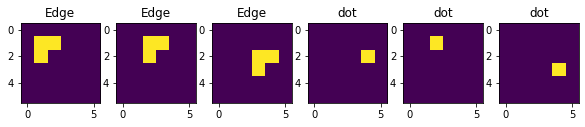

In [3]:
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(10, 15))
axs[0].imshow(X_train[0])
axs[0].set_title("Edge")
axs[1].imshow(X_train[1])
axs[1].set_title("Edge")
axs[2].imshow(X_train[2])
axs[2].set_title("Edge")
axs[3].imshow(X_train[3])
axs[3].set_title("dot")
axs[4].imshow(X_train[4])
axs[4].set_title("dot")
axs[5].imshow(X_train[5])
axs[5].set_title("dot");

## Creating util functions
- Creating functions to define a  convolutional layer nad a dense layer.
- The notation and structure is inspired by the documents in teams: "10_numExample\2022\2022-P0\2022-P0-T1_FCNNs & CNNs - F&B pass\00_Examples_Given\FCCNs-CNNs-FBPass_EX1.pdf"

You will find:
1. A Convolutional layer: Take a filter F and an image X and performs convolution across the image.\
A very simple conv. layer => no padding enabled, and assuming grayscale / 2D input.
2. A max pool layer: Simply chooses the maximum value within a square.\
    Samples down the problem, by removing some information.\
    The idea is that the conv. layer will give large values  ($\pm$) where a feature is detected,\
    so we should select for these large values to pass on. Other information is not as important.

    Also: keeps the indexes of where the maximas where taken from - which is needed in the backwards pass.

3. Activation functions and loss functions and their derivatives.
- ReLU is used after the conv layer, in order to remove negative values that might have appeared from the conv. step.
- Sigmoid is used after the classification layer; as we are only interested in the outputs 0, and 1.
- BCE loss function (binary cross entropy) finds the distance / cross entropy between your answer and the target - for a binary (0/1) classification.

The reason we also need the derivatives, is that they are used in the backwards pass.

In [4]:
def convolution(X, F, b=0, s=1):
    """
    A Convolutional layer:
    Inputs:
        - X: image 2D
        - F: Kernel / filter
        - b: The bias - which will be used / updated in our BPass.
        - s: the stride / how far the kernel moves between each convolution operation.

    Returns:
        - z: the convolved image (as padding is not implemented, the size will be reduced by 1 in each dimension)

    """
    w_out = (X.shape[0] - F.shape[0])//s + 1
    h_out = (X.shape[1] - F.shape[1])//s + 1
    z = np.zeros((h_out, w_out))
    for j in range(0, w_out, s):
        for i in range(0, h_out, s):
            z[i,j] = X[i:i+F.shape[1], j:j+F.shape[0]].flatten().dot(F.flatten()) + b
    return z

def max_pool(X, k, s):
    """
    A max pool layer. 
    Input:
    - X: a 2D image, usually after convolution is applied.
    - k: the size of the max-pool-kernel
    - s: the stride of the max pool kernel.
    Output:
    - z: the max-pooled image
    - idx: indexes of max values
    """
    h_out = (X.shape[0] - k)//s + 1
    w_out = (X.shape[1] - k)//s + 1
    z = np.zeros((h_out, w_out))
    idx = []
    for j in range(0, h_out):
        for i in range(0, w_out):
            block = X[j*k:j*k+k, i*k:i*k+k]
            z[j,i] = np.max(block)
            index = np.add(np.unravel_index(block.argmax(), block.shape), (j*k, i*k))
            idx.append(index) # Save indices of max values for backward pass!
    return z, idx


"""
Different activation functions, and their derivatives.
"""
def ReLU(x):
    return abs(x) * (x > 0) 
def d_ReLU(x): # differentiated!
    return 1 * (x > 0)
def sigmoid(x):
    y = np.exp(x)
    return y / (1 + y)
def d_sigmoid(x): # differentiated!
    y = sigmoid(x)
    return y * (1.0 - y)

"""
The binary cross entropy loss function, and its derivative.
"""
def bce_loss(y, p):
    # Binary cross-entropy loss function
    return -(y * np.log10(p) + (1-y) * np.log10(1-p))
def d_bce_loss(y,p): # differentiated!
    # Derivative wrt. p
    return (1 - y) / (1 - p) - (y / p)

## The forward pass:

<img src="images/FPass.png" alt="drawing" style="width:1000px;"/>

Above, I have tried to illustrate the architecture I am using, as well as names I use between each component. 

Below, is the same - implemented in code.

**Notice**, that we did not implement the densly connected neuron as a utility function above. That is because all this node does, is to multiply all weights with all outputs, and sum them together. This can be solved using the dot operator, and then adding the bias seperately afterwards. 

In [5]:
# Initialize trainable parameters
b1 = 1.0 # conv Bias
F = np.array([[-0.5,0.5, -0.5],[-0.5,0.5, -0.5], [-0.5,0.5, -0.5]]) # Kernel
w4 = np.random.randn(4) # Initialize random weights
b4 = 0
####################
### Forward pass ###
####################
# Input image
X = X_train[0]
# Convolution
z1 = convolution(X, F, b1, s=1) # Perform convolution
a1 = ReLU(z1) # Apply AF
# Maxpool 
a2, max_idx = max_pool(a1, k=2, s=2)
# Flatten
a3 = a2.flatten()
# Densly connected
z4 = w4.dot(a3) + b4
a4 = sigmoid(z4)
# Loss
loss = bce_loss(y_train[0], a4)
print("a4:",  a4)
print("target:", y_train[0], "= an edge")
print("Loss:", loss)


a4: 0.21314236135824588
target: 1 = an edge
Loss: 0.671330227076936


Our network is currently just giving a random output, as all parameters were initialized randomly.

**Now** we need to train these parameters, using the loss.

## Backwards pass

<img src="images/BPass.png" alt="drawing" style="width:800px;"/>

Allright, there is a lot to take in here - but the math itself is just using a simple principle: the chain rule:

$\frac{dx}{dy} = \frac{dx}{dz} * \frac{dz}{dy}$

What we want to find in the end, is how the loss (L) is affected by a change in a trainable parameter, say $w_4$: $\frac{dL}{dw_4}$.

Using a lot of chain rules - and by passing info backwards from one layer to the previous, this can be achieved.

**NB** notice that the densly connected layer is implemented as a dot product above: $z_4 = w_4 \cdot a_3 + b_4$,\
making $z_4$ differentiable with respect to both $w_4$ and $b_4$.


The only step that is not shown here, is how we do backwards pass across the convolution, as it is a bit more *involved*. It can actually be done using convolution itself:

![deriv](images/deriv_as_conv.png)

If you want to learn more, navigate to: "10_numExample\2022\2022-P0\2022-P0-T1_FCNNs & CNNs - F&B pass\00_Examples_Given\FCCNs-CNNs-FBPass_EX1.pdf"


**Also** in order to actually update/learn the trainable parameters, we use the "delta" rule:

$p^{old} = p^{new} - \alpha \cdot \delta$

... where $\alpha$ is the learning rate.


In [6]:
alpha = 0.1
F_old = F.copy()

####################
### Backward pass ##
####################
# Fully connected layer:
delta = d_bce_loss(y_train[0], a4) * d_sigmoid(z4)
b4 = b4 - alpha * delta # Update bias
delta = delta * a3 # Gradient wrt. w4
w4 = w4 - alpha * delta # Update weights
# Unflatten
delta = delta.reshape(a2.shape)
# Maxpooling layer
d = np.zeros(a1.shape)
for idx, grad in zip(max_idx, delta.flatten()):
    i, j = idx[0], idx[1]
    d[i,j] = grad
delta = d
# Backprop through ReLU
delta = d_ReLU(z1) * delta
# Convolution layer
grad_b1 = delta.sum() # dL/d(b1)
b1 = b1 - alpha * grad_b1 # Update bias
grad_F = convolution(X, delta)
F = F - alpha * grad_F # Update weights

In [7]:
F_old, F

(array([[-0.5,  0.5, -0.5],
        [-0.5,  0.5, -0.5],
        [-0.5,  0.5, -0.5]]),
 array([[-0.5       ,  0.61802865, -0.5       ],
        [-0.5       ,  0.61802865, -0.38197135],
        [-0.5       ,  0.61802865, -0.5       ]]))

**After running a single BPass** we see that trainable parameter F was altered slightly. 

Now, all that is left is to repeat this process over and over, for more training data. It is important that the training data contains examples of both classes we want to classify.

In [18]:
def simple_fit(X_train, y_train, lr=0.1, epochs=10, scale=255):
    """
    Simple fit function, doing complete FBpass over a training set.add
    Inputs:
    - Xtrain: A list of training samples. (2D images)
    - y_train: labels - 0 or 1.
    - lr: learning rate
    - epochs: no. epochs to do.
    - scale: scale of inputs - a simple normalization.
    Returns:
    - model: containing all trainable parameters at final iteration.
    - losses: history of losses recorded after each Bpass.
    """
    # Initialize randomly
    b1 = 1.0 # conv Bias
    F = np.array([[-0.5,0.5, -0.5],[-0.5,0.5, -0.5], [-0.5,0.5, -0.5]]) # Kernel
    #F = np.array([[0.1,-0.1],[-0.1,0.1]]) # Kernel
    w4 = None 
    b4 = 0 # neuron Bias
    lr = lr # Learning rate
    losses = []

    for e in range(epochs):
        for i, X in enumerate(X_train):        
            X = X/scale # normalize
            ####################
            ### Forward pass ###
            ####################
            # Convolution
            z1 = convolution(X, F, b1, s=1) # Perform convolution
            a1 = ReLU(z1) # Apply AF
            # Maxpool and flatten
            a2, max_idx = max_pool(a1, k=2, s=2)
            a3 = a2.flatten()
            # Initialize to correct size
            if e==0 and i==0:
                w4 = np.random.randn(len(a3))
            # Fully-connected layer
            z4 = w4.dot(a3) + b4
            a4 = sigmoid(z4)
            # Loss
            loss = bce_loss(y_train[i], a4)
            losses.append(loss)

            if math.isnan(losses[-1]):
                # Could not find solution, restarting
                # An edgecase that happens if the learning rate is too big: unstable system!
                return simple_fit(X_train, y_train, lr=lr, epochs=epochs, scale=scale)

            ####################
            ### Backward pass ##
            ####################
            # Fully connected layer:
            delta = d_bce_loss(y_train[i], a4) * d_sigmoid(z4)
            b4 = b4 - lr * delta # Update bias
            delta = delta * a3 # Gradient wrt. w4
            w4 = w4 - lr * delta # Update weights

            # NEXT, we unflatten the backpropagated derivative:
            delta = delta.reshape(a2.shape)
            # maxpooling layer
            d = np.zeros(a1.shape)
            for idx, grad in zip(max_idx, delta.flatten()):
                i, j = idx[0], idx[1]
                d[i,j] = grad
            delta = d
            # Backprop through delta
            delta = d_ReLU(z1) * delta
            # The conv bias
            grad_b1 = delta.sum() # dL/d(b1)
            b1 = b1 - lr * grad_b1 # Update bias
            # The conv kernel
            grad_F = convolution(X, delta)
            F = F - lr * grad_F # Update weights

    model = {"b1":b1, "F":F, "b4":b4, "w4":w4}
    #if math.isnan(losses[-1]):
    #    print("Could not find minima, restarting")
    #    return simple_fit(X_train, y_train, lr=lr, epochs=epochs, verbose=verbose, scale=scale)
    return model, losses

#### Let us test the simple framework: Edge detection

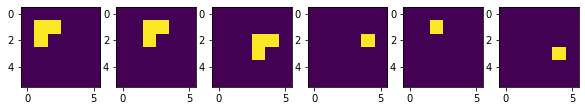

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(10, 15))
# plotting the loss
axs[0].imshow(X_train[0])
axs[1].imshow(X_train[1])
axs[2].imshow(X_train[2])
axs[3].imshow(X_train[3])
axs[4].imshow(X_train[4])
axs[5].imshow(X_train[5]);

Running the model on all 6 training samples. 3 from each class.

In [64]:
model, losses = simple_fit(X_train, y_train, lr=0.05, epochs=600, scale=1)

Plotting the loss of the training sequence

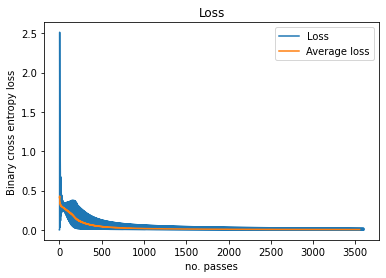

In [65]:
# Average loss over time
N=50
avg = np.convolve(losses, np.ones(N)/N, mode='valid')
# plotting the loss
plt.title("Loss")
plt.xlabel("no. passes")
plt.ylabel("Binary cross entropy loss")
plt.plot(np.linspace(0, len(losses), len(losses)), losses, label="Loss")
plt.plot(np.linspace(0, len(avg), len(avg)), avg, label="Average loss")
plt.legend();

We see how the loss started stabilizing after passing going over around 1000 training samples.

Next step is to do some predictions (basically just a forward pass) - and see how the model performs.

In [ ]:
def prediction(model, test_data, scale=255):
    """
    Uses a model to predict on test data.
    Is the same as running Fpasses for all test data.
    Inputs:
    - A model aon the same format as outputted by "simple_fit".
    - test_data: set of 2D images to predict.
    - Scale: scale of test data.
    Outputs:
    - A list of predictions.
    """
    predictions = np.zeros(len(test_data))
    for i, X in enumerate(test_data):
        X = X/scale # normalize
        b1 = model["b1"]
        F = model["F"]
        b4 = model["b4"]
        w4 = model["w4"]
        ####################
        ### Forward pass ###
        ####################
        # Convolution
        z1 = convolution(X, F, b1, s=1) # Perform convolution
        a1 = ReLU(z1) # Apply AF
        # Maxpool and flatten
        a2, max_idx = max_pool(a1, k=2, s=2)
        a3 = a2.flatten()
        # Fully-connected layer
        z4 = w4.dot(a3) + b4
        a4 = sigmoid(z4)
        # Loss
        predictions[i] = a4
    return predictions

In [66]:
predictions = prediction(model, X_train, scale=1)
print("predictions:", np.round(predictions, 1))
print("targets:", np.round(y_train, 1))

predictions: [1. 1. 1. 0. 0. 0.]
targets: [1 1 1 0 0 0]


Great, our model manages to predict on the training dataset - meaning that the model has succesfully mapped the input to the output. However, for a model to be really useful it has to generalize.

Next step: testing out our model, on some unseen test data.

Test_targets: [1 0]
test predictions: [1. 0.]


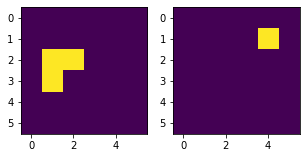

In [67]:
# Inventing some new data of same format
edge4 = np.array([[0,0,0,0,0, 0], [0,0,0,0,0,0], [0,1,1,0,0,0], [0,1,0,0,0,0], [0,0,0,0,0,0], [0, 0, 0, 0, 0, 0]])
singles4 = np.array([[0,0,0,0,0,0], [0,0,0,0,1,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0, 0, 0, 0, 0, 0]])
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(5, 8))
axs[0].imshow(edge4)
axs[1].imshow(singles4)
test_preds = [prediction(model, [edge4], scale=1)[0], prediction(model, [singles4], scale=1)[0]]
print("Test_targets:", np.asarray([1, 0]))
print("test predictions:", np.round(test_preds, 2))

It managed to classify new data succesfully, however at a slightly lower certainty; lets look at some other interesting topics:

## Data shuffle

Something as simple as shuffling the data can have a big impact on convergence rate. Notice in the "simple_fit()" the model would first see three samples of case 1, then case 0. This makes the model start specializing too heavily towards one case before seeing the other, making the model very "jittery". Lets see the effect of simply shuffling the data first:

In [68]:
# Since our dataset is so small, I will manually shuffle it to make sure we don't get the same repeating sequences.
shuffle = np.array([0, 3, 1, 4, 2, 5])
X_train_shuffled = X_train[shuffle]
y_train_shuffled = y_train[shuffle]
y_train, y_train_shuffled

(array([1, 1, 1, 0, 0, 0]), array([1, 0, 1, 0, 1, 0]))

In [69]:
model_shuffle, losses_shuffle = simple_fit(X_train_shuffled, y_train_shuffled, lr=0.05, epochs=600, scale=1)

predictions = prediction(model_shuffle, X_train, scale=1)
print("predictions:", np.round(predictions, 1))
print("targets:", np.round(y_train, 1))

predictions: [1. 1. 1. 0. 0. 0.]
targets: [1 1 1 0 0 0]


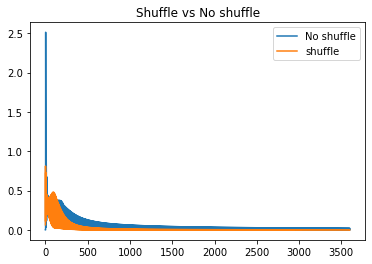

In [72]:
plt.title("Shuffle vs No shuffle")
plt.plot(np.linspace(0, len(losses), len(losses)), losses, label="No shuffle")
plt.plot(np.linspace(0, len(losses_shuffle), len(losses_shuffle)), losses_shuffle, label="shuffle")
plt.legend();

**NB** \
It will not *always* be apparent that shuffeling causes less jitter in the convergence, but on average that should be the case. My results often looked like this:

![shuffle](images/shuffle%20vs%20no%20shuffle.png)

## Looking at batching
On the loss-graph from the previous attempt we see that the loss is very "jittery" - as we do a full BPass for each training sample.

So, the model will try to improve predicting a single sample, which will often be going in a wrong direction compared to other samples.

Batching, is when we use N training sample at the time to update our parameters; usually averaging our losses / our deltas before doing a pass.

The advantages of such a methods is:
- Smalles "spikes" / smoother convergence
- Typically faster training: The backwards pass is not done for each sample, speeding up the training. This is especially important for huge networks, and will not be apparent here.

In [36]:
"""
The same fit as above, only with batches added.
"""
def simple_batch_fit(X_train, y_train, lr=0.1, epochs=10, scale=255, batch_size=3):
    """
    Simple batch fit function, doing complete FBpass over a training set.add
    Inputs:
    - Xtrain: A list of training samples. (2D images)
    - y_train: labels - 0 or 1.
    - lr: learning rate
    - epochs: no. epochs to do.
    - scale: scale of inputs - a simple normalization.
    - batch_size: how many samples per batch.
    Returns:
    - model: containing all trainable parameters at final iteration.
    - losses: history of losses recorded after each Bpass.
    """
    # Initialize randomly
    b1 = 1.0 # conv Bias
    F = np.array([[-0.5,0.5, -0.5],[-0.5,0.5, -0.5], [-0.5,0.5, -0.5]]) # Kernel
    #F = np.array([[0.1,-0.1],[-0.1,0.1]]) # Kernel
    w4 = None 
    b4 = 0 # neuron Bias
    lr = lr # Learning rate
    losses = []

    for e in range(epochs):
        batch_loss=0
        batch_delta=0
        
        for i, X in enumerate(X_train):
            X = X/scale # normalize
            ####################
            ### Forward pass ###
            ####################
            # Convolution
            z1 = convolution(X, F, b1, s=1) # Perform convolution
            a1 = ReLU(z1) # Apply AF
            # Maxpool and flatten
            a2, max_idx = max_pool(a1, k=2, s=2)
            a3 = a2.flatten()
            # Initialize to correct size
            if e==0 and i==0:
                w4 = np.random.randn(len(a3))
            # Fully-connected layer
            z4 = w4.dot(a3) + b4
            a4 = sigmoid(z4)
            # Loss
            loss = bce_loss(y_train[i], a4)
            delta = d_bce_loss(y_train[i], a4) * d_sigmoid(z4)
            if math.isnan(loss):
                # Could not find solution, restarting
                return simple_batch_fit(X_train, y_train, lr=lr, epochs=epochs, scale=scale, batch_size=batch_size)

            batch_loss+=loss/batch_size
            losses.append(batch_loss)
            batch_delta+=delta/batch_size
            
            if (i+1)%batch_size==0:
                ####################
                ### Backward pass ##
                ####################
                # Fully connected layer:
                delta = batch_delta
                b4 = b4 - lr * delta # Update bias
                delta = delta * a3 # Gradient wrt. w4
                w4 = w4 - lr * delta # Update weights

                # NEXT, we unflatten the backpropagated derivative:
                delta = delta.reshape(a2.shape)
                # maxpooling layer
                d = np.zeros(a1.shape)
                for idx, grad in zip(max_idx, delta.flatten()):
                    i, j = idx[0], idx[1]
                    d[i,j] = grad
                delta = d
                # Backprop through delta
                delta = d_ReLU(z1) * delta
                # The conv bias
                grad_b1 = delta.sum() # dL/d(b1)
                b1 = b1 - lr * grad_b1 # Update bias
                # The conv kernel
                grad_F = convolution(X, delta)
                F = F - lr * grad_F # Update weights

                batch_loss = 0
                batch_delta = 0

    model = {"b1":b1, "F":F, "b4":b4, "w4":w4}
    return model, losses

In [53]:
model_batch_1, losses_batch_1 = simple_batch_fit(X_train_shuffled, y_train_shuffled, lr=0.05, epochs=200, scale=1, batch_size=1)
model_batch_2, losses_batch_2 = simple_batch_fit(X_train_shuffled, y_train_shuffled, lr=0.05, epochs=600, scale=1, batch_size=2)
model_batch_3, losses_batch_3 = simple_batch_fit(X_train_shuffled, y_train_shuffled, lr=0.05, epochs=800, scale=1, batch_size=3)

print("Batch-size=1")
print("Targets:", y_train)
print("Predictions:", np.round(prediction(model_batch_1, X_train, scale=1),2))
print("Batch-size=2")
print("Targets:", y_train)
print("Predictions:", np.round(prediction(model_batch_2, X_train, scale=1),2))
print("Batch-size=3")
print("Targets:", y_train)
print("Predictions:", np.round(prediction(model_batch_3, X_train, scale=1),2))


Batch-size=1
Targets: [1 1 1 0 0 0]
Predictions: [1.   1.   1.   0.   0.01 0.  ]
Batch-size=2
Targets: [1 1 1 0 0 0]
Predictions: [0.95 0.95 0.93 0.08 0.12 0.12]
Batch-size=3
Targets: [1 1 1 0 0 0]
Predictions: [0.95 0.99 0.85 0.   0.09 0.  ]


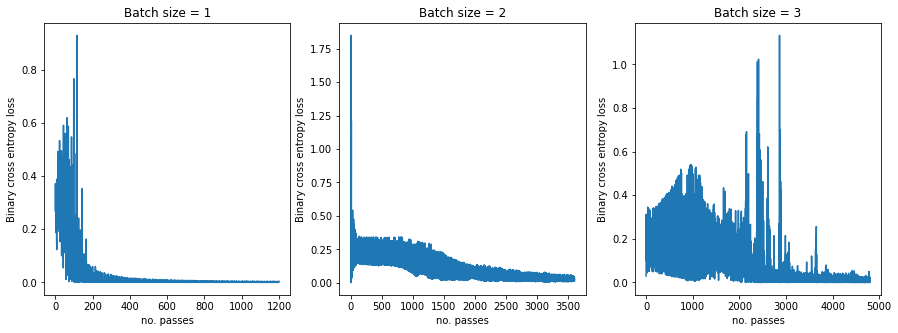

In [54]:
# Average loss over time
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axs[0].set_title("Batch size = 1")
axs[0].set_xlabel("no. passes")
axs[0].set_ylabel("Binary cross entropy loss")
axs[0].plot(np.linspace(0, len(losses_batch_1), len(losses_batch_1)), losses_batch_1)

axs[1].set_title("Batch size = 2")
axs[1].set_xlabel("no. passes")
axs[1].set_ylabel("Binary cross entropy loss")
axs[1].plot(np.linspace(0, len(losses_batch_2), len(losses_batch_2)), losses_batch_2)

axs[2].set_title("Batch size = 3")
axs[2].set_xlabel("no. passes")
axs[2].set_ylabel("Binary cross entropy loss")
axs[2].plot(np.linspace(0, len(losses_batch_3), len(losses_batch_3)), losses_batch_3);

**NB** look at the scale of the y-axis: the spikes / jitters in the y axis is a lot smoother. 

## TODO / EXTRA
1. If you want to classify more complex patters, depth need to be added to the conv net.
2. If you want to classify more than one / two patterns, a bigger conv layer is needed.
- Also; a different activation funcion than sigmoid; as it only gives answers close to 0 or 1. (use softmax)
- The loss function would then be full cross entropy function.
